# PCM correlation models 
This demo shows two ways to use the PCM correlation model to test hypotheses about the correlation between activity patterns. 
For an alternative way of modelling correlations using PCM feature models, see demo_correlation_feature.ipynb.  

- In the first part of this jupyter notebook, we'll focus on the simple case on how to get the maximum-likelihood estimate of the correlation between **two** activity patterns. 

- In the second part, we will consider a slightly more complex situation in which we want to estimate the true correlation between two **sets** of activity patterns measured under two different conditions.  For example, we might want to know how the activity patterns related to the observation of 3 hand gestures correlate (at a gesture-specific level) with the activity patterns related to the execution of the same 3 hand gestures.

In [1]:
# First import necessary libraries
#(make sure PcmPy is in your python path)
import PcmPy as pcm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import exp, sqrt
import scipy.stats as sps

## 1. Estimating the true correlation between two patterns
How similar/correlated are two activity patterns? It is easy to test whether 2 activity patterns are more correlated than chance (i.e., zero correlation). However, even if the two conditions elicit exactly the same pattern, the correlation will not be 1, simply because of measurement noise. To approach this problem, we can obtain the maximum-likelihood estimator of the correlations, using repeated measurements of the same two activity patttens across multiple runs (repetitions). Note that this estimator is not unbiased, and can get unstable for very low signal to noise datasets - so we need to be caseful in the interpretation and inference.   

In the simplest case of 2 activity patterns, the model will have 3 model parameters: 
- The correlation between **A** and **B**. 
- The strength (variance across voxels) of the activity patterns associated with condition **A**. 
- The strength (variance across voxels) of the activity patterns associated with condition **B**. 

And one additional noise parameter: 
- The variance of the measurement noise across repeated measures of the same pattern. 

To ensure that the variance parameters are positive, and the correlation between $-1,1$, we fit the following nonlinear transforms:

$\theta_1 = atanh(r)$ 

$\theta_2 = log(var(x_A))$ 

$\theta_3 = log(var(x_B))$ 

$\theta_{\epsilon} = log(var(\epsilon))$ 

These (hyper-)parameters are collectively referred to by $\theta$ (thetas). Here we will compare different models by using the (Type II) maximum likelihood to approximate the model evidence:

$p(Y|r) \approx \underset{\theta}{\operatorname{max}}{p(Y|r,\theta)}.$

### 1.1 Simulating the data
In this example, we will use some simulated data with a known correlation between he true (noiseless) activity patterns (`Mtrue`). In this example, we set that our two activity patterns are positively correlated with a true correlation of 0.7.

>Note that in `pcm.CorrelationModel` we set `num_items` to 1, as we have only 1 activity pattern per condition, and we set `cond_effect` to `False`, as we do not want to model the overall effect between different conditions (each with multiple items, see section 2 below).

The true model (`Mtrue`) has 2 hyper-parameters reflecting the signal strength (or true pattern variance) for each activity pattern (`item`). In addition to the 2 model parameters, PCM also fits one parameter for the variance of the measurement noise.


In [2]:
Mtrue = pcm.CorrelationModel('corr', num_items=1, corr=0.7, cond_effect=False)
print(f"The true model has {Mtrue.n_param} hyper parameters")

The true model has 2 hyper parameters


We can now use the simulation module to create 20 datasets (e.g., one per simulated participant) with a relatively low signal-to-noise level (0.2:1). We will use a design with 2 conditions and 8 partitions/runs per dataset.
>Note that the thetas are specified as log(variance).

In [3]:
# Create the design. In this case it's 2 conditions, across 8 runs (partitions)
cond_vec, part_vec = pcm.sim.make_design(n_cond=2, n_part=8)

# Starting from the true model above, generate 20 datasets/participants 
# with relatively low signal-to-noise ratio (0.2:1)
# Note that signal variance is 0.2 - noise variance is by default set to 1 
# For replicability, we are using a fixed random seed (100)
rng = np.random.default_rng(seed=100)
signal = np.random.gamma(shape=2,scale=0.2,size=(20,))
D = pcm.sim.make_dataset(model=Mtrue, \
    theta=[0,0], \
    cond_vec=cond_vec, \
    part_vec=part_vec, \
    n_sim=20, \
    signal=signal,\
    rng=rng)

First let's look at the correlation that we get when we calculate the *naive* correlation—i.e. the correlation between the two estimated activity patterns. 

In [4]:
def get_corr(X,cond_vec):
    """
        Get normal correlation
    """
    p1 = X[cond_vec==0,:].mean(axis=0)
    p2 = X[cond_vec==1,:].mean(axis=0)
    return np.corrcoef(p1,p2)[0,1]

r = np.empty((20,))
for i in range(20):
    data = D[i].measurements
    r[i] = get_corr(data, cond_vec)
print(f'Estimated mean correlation: {r.mean():.4f}')

Estimated mean correlation: 0.3823


As we can see, due to measurement noise, the estimated mean correlation is much lower than the true value of 0.7.

This is not a problem if we just want to test the hypothesis that the true correlation is larger than zero. Then we can just calculate the individual correlations per subject and test them against zero using a t-test. 

However, if we want to test whether the true correlation has a specific value (for example `true_corr=1`, indicating that the activity patterns are the same), or if we want to test whether the correlations are higher in one brain area than another, then this becomes an issue. 

Different brain regions measured with fMRI often differ dramatically in their signal-to-noise ratio. Thus, we need to take into account our level of measurement noise. PCM can do that.

### 1.2 Fitting the data
To get the maximum-likelihood estimate of the correlation of A and B we  generare a flexible model (`Mflex`) that has the correlation as a parameter that is being optimized. 

In [5]:
# Now make the flexible model 
Mflex = pcm.CorrelationModel("flex", num_items=1, corr=None, cond_effect=False)
print(f"The flexible model has {Mflex.n_param} hyper parameters")

The flexible model has 3 hyper parameters


We can now fit the models to all datasets in one go. The resulting dataframe `T` has the log-likelihoods, noise variances, and iterations for the different dataset (rows). The second return argument `theta` contains the parameters for the model fit.   


In [6]:
# In this case, we the mean of the block is not modelled 
# This is valid if the measurement noise for A and B within a block are independent. 
# We don't need to include a scale parameter given that we don't have a fixed model 
T, theta = pcm.fit_model_individ(D, Mflex, fixed_effect=None, fit_scale=False, verbose=False)
T.head()

variable,likelihood,noise,iterations
model,flex,flex,flex
0,-234.995264,0.871523,4.0
1,-220.292718,0.888130,9.0
2,-288.563699,1.082561,4.0
3,-256.914320,0.971128,5.0
4,-243.122552,0.935571,5.0


We can also fit all the datasets together with one single model, allowing for a seperate scale and noise paramters for each subject. 

In [7]:
# We can either include or not include a individual scale factor. 
# Given that that the variance parameters (and correlation parameter) are  the same across the entire group, but 
# since we cannot assume that the signal-to-noise ratio is the same across participants, we include a scale factor.
T_gr, theta_gr = pcm.fit_model_group(D, Mflex, fixed_effect=None, fit_scale=True, verbose=False)
T_gr.head()

variable,likelihood,noise,scale,iterations
model,flex,flex,flex,flex
0,-236.284275,0.884344,0.962070,6
1,-220.834427,0.888066,0.236486,6
2,-289.068087,1.085914,1.456402,6
3,-257.525382,0.964906,1.070475,6
4,-243.567883,0.931844,0.712362,6


As you can see, the likelhood of each of the datasets is a bit lower than for the individual fit. 

### 1.3 Interpreting the fitted parameters 
We can now get the signal variance (theta[0], theta[1]), the correlation parameters (theta[2]), and the noise parameter (theta[3]) from the parameter. 
Note that all the variance parameter are internally represented as log(var) and the correlation parameters are fisherz(r), so we need to make sure we transform it.  

The overall estimated SNR is $SNR  = \sigma_1 \sigma_2/\sigma^2_e$. 
As a diagnostic plot, we recommend to plot the correlation parameter against the estiamted SNR. 

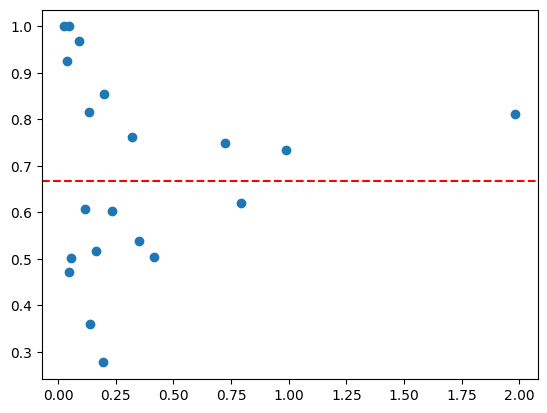

In [8]:
# Plot individual parameter estimates against the individual noise level
sigma2_1 = np.exp(theta[0][0]) # reversing the log-transform
sigma2_2 = np.exp(theta[0][1]) # reversing the log-transform
r_indiv = Mflex.get_correlation(theta[0]) # Inverse fisher-z transform
sigma2_e = np.exp(theta[0][3]) # reversing the log-transform
SNR = np.sqrt(sigma2_1*sigma2_2)/sigma2_e
plt.scatter(SNR, r_indiv)

# Add the group estimate as a horizontal line
theta_g,_= pcm.group_to_individ_param(theta_gr[0],Mflex,20)
r_group = Mflex.get_correlation(theta_g)
plt.axhline(r_group[0], color='red', linestyle='--')

As we can see, the group estimate (red line) is quite close to the true (simulated) value. Individual estimates are downward bias with increasing variance, as the SNR decreases. 

### 1.4 Inference via bootstrap 
TO BE ADDED

## 2. Testing for specific correlations between activity patterns across two conditions
In the second part of this notebook, we will simulate data from a hypothetical experiment, in which participants observed 3 hand gestures or executed the same 3 hand gestures. Thus, we have 3 items (i.e., the hand gestures) in each of 2 conditions (i.e., either observe or execute). 

We are interested in the average correlation between the patterns associated with observing and executing action A, observing and executing action B, and observing and executing action C, while accounting for overall differences in the average patterns of observing and executing. To solve this problem, we again calculate the likelihood of the data given a range of specific correlations $p(Y|r)$.

In this case we have the following parameters to estimate: 
- The variance of the pattern component that is common to all observed actions. 
- The variance of the pattern component that is common to all executed actions. 
- The variance of the movement-specific activity patterns associated with observing actions.
- The variance of the movement-specific activity patterns associated with executing actions.
- The correlation between A and B 


- Finally, we again have a parameter for the noise variance. 

### 2.1 Data simulation
First, we create our true model (`Mtrue`): one where the all actions are equally strongly encoded in each condition, but where the strength of encoding can differ between conditions (i.e., between observation or execution). 

>For example, we could expect the difference between actions to be smaller during observation than during execution (simply due to overall levels of brain activation). 

Next, we also model the covariance between items within each condition with a condition effect (i.e., by setting `condEffect` to `True`). Finally, we set the ground-truth correlation to be 0.7. 

In [9]:
Mtrue = pcm.CorrelationModel('corr', num_items=3, corr=0.7, cond_effect=True, within_cov=None)
print(f"The true model has {Mtrue.n_param} hyper parameters")

The true model has 4 hyper parameters


These four parameters are concerned with the condition effect and item effect for observation and execution, respectively. Visualizing the components of the second moment matrix (also known as variance-covariance, or simply covariance matrix) helps to understand this:

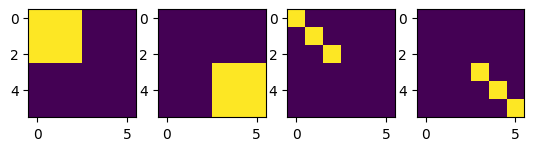

In [10]:
H = Mtrue.n_param
for i in range(H):
    plt.subplot(1, H, i+1)
    plt.imshow(Mtrue.Gc[i,:,:])

>The first two components plotted above reflect the condition effect and model the covariance between items within each condition (observation, execution). The second two components reflect the item effect and model the item-specific variance for each item (3 hand gestures) in each condition.

To Simulate a dataset, we need to simulate an experimental design. Let's assume we measure the 6 trial types (3 items x 2 conditions) in 8 imaging runs and submit the beta-values from each run to the model as $\mathbf{Y}$. 

We then generate a dataset where there is a strong overall effect for both observation (exp(0)) and execution (exp(1)). In comparison, the item-specific effects for observation (exp(-1.5)) and execution (exp(-1)) are pretty weak (this is a rather typical finding).

>Note that all hyper parameters are log(variances)—this helps us to keep variances positive and the math easy. 

In [11]:
# Create the design. In this case it's 8 runs, 6 trial types
cond_vec, part_vec = pcm.sim.make_design(n_cond=6, n_part=8)
#print(cond_vec)
#print(part_vec)

# Starting from the true model above, generate 20 datasets/participants 
# with relatively low signal-to-noise ratio (0.2:1)
D = pcm.sim.make_dataset(model=Mtrue, \
    theta=[1,2.7,0.4,0.2], \
    cond_vec=cond_vec, \
    part_vec=part_vec, \
    n_sim=20, \
    signal=signal)

As a quick check, let's plot the predicted second moment matrix of our true model (using the simulation parameters) and the crossvalidated estimate from the first dataset. 

Text(0.5, 1.0, 'dataset')

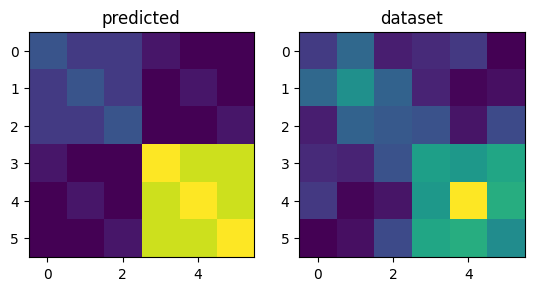

In [12]:
# Get the predicted G-matrix  from the true model
G,_ = Mtrue.predict([1,2.7,0.4,0.2])

# The estimated G-matrix from the first dataset 
trial_type = D[1].obs_descriptors['cond_vec']
G_hat,_ = pcm.est_G_crossval(D[1].measurements, trial_type, part_vec)

# Visualize the second moment (G) matrices
plt.subplot(1,2,1)
plt.imshow(G)
plt.title('predicted')

plt.subplot(1,2,2)
plt.imshow(G_hat)
plt.title('dataset')

### 2.2 Fitting the data 
We now use a flexible correlation model (`Mflex`), that also models the condition effect as random effect.

In [13]:

# Now make the flexible model 
Mflex = pcm.CorrelationModel("flex", num_items=3, corr=None, cond_effect=True)


We can now fit the model to the datasets in one go. The resulting dataframe `T` has the log-likelihoods for each model (columns) / dataset (rows). The second return argument `theta` contains the parameters for each model fit. 

In [14]:
# In this case, we model the block effect as a mixed effect
# We don't need to include a scale parameter given that we don't have a fixed model 
T, theta = pcm.fit_model_individ(D, Mflex, fixed_effect='block', fit_scale=False, verbose=False)
T.head()

variable,likelihood,noise,iterations
model,flex,flex,flex
0,-954.975855,1.025321,5.0
1,-805.785910,0.925755,6.0
2,-936.842608,0.981364,5.0
3,-898.205976,0.920522,5.0
4,-896.887711,0.984830,5.0


In [15]:
# Now the group fit  
T_gr, theta_gr = pcm.fit_model_group(D, Mflex, fixed_effect='block', fit_scale=True, verbose=False)
T_gr.head()

variable,likelihood,noise,scale,iterations
model,flex,flex,flex,flex
0,-955.732203,1.024551,1.369674,7
1,-806.586841,0.938671,0.074058,7
2,-938.212406,0.982109,1.523723,7
3,-899.343701,0.920545,1.427495,7
4,-897.823097,0.979908,0.681513,7


### 2.3 Interpreting the Fit 
Again, the key diagnostic plot is to look at the ML estimates of the parameters against the overall SNR. Note that the first two parameters are the main condition effects  

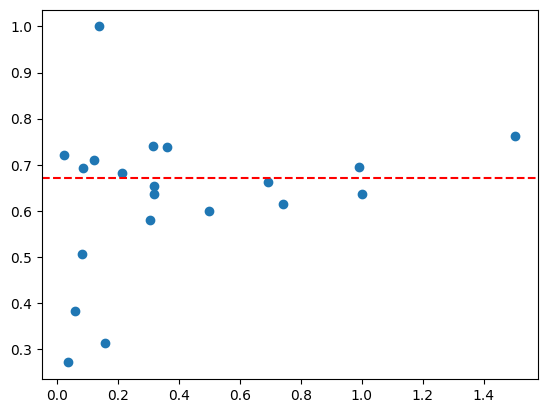

In [16]:
# Plot individual parameter estimates against the individual noise level
sigma2_1 = np.exp(theta[0][2])
sigma2_2 = np.exp(theta[0][3])
r_indiv = Mflex.get_correlation(theta[0])
sigma2_e = np.exp(theta[0][5])
SNR = np.sqrt(sigma2_1*sigma2_2)/sigma2_e
plt.scatter(SNR, r_indiv)

# Add the group estimate as a horizontal line
theta_g,_= pcm.group_to_individ_param(theta_gr[0],Mflex,20)
r_group = Mflex.get_correlation(theta_g)
plt.axhline(r_group[0], color='red', linestyle='--')